In [1]:
# Configuração do ambiente
import os
from dotenv import load_dotenv

load_dotenv()
#os.environ['SPARK_VERSION'] = os.getenv('SPARK_VERSION')
os.environ['PYSPARK_PYTHON'] = os.getenv('PYSPARK_PYTHON') 
os.environ['SPARK_HOME'] = os.getenv('SPARK_HOME')
os.environ['HADOOP_HOME'] = os.getenv('HADOOP_HOME')
os.environ['JAVA_HOME'] = os.getenv('JAVA_HOME')

In [2]:
# PySpark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *

# Data quality
import pydeequ
from pydeequ.analyzers import *

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

In [3]:
# Seaborn settings
sns.set_theme(
    context="notebook",
    style="ticks",
    palette="colorblind",
    font_scale=.8, 
    rc = {
        "axes.grid": False,
        "grid.alpha": .2,
        "axes.titlesize": "x-large",
        "axes.titleweight": "bold",
        "axes.titlepad": 20,
        'legend.frameon': False
    }
)

In [4]:
# Configuração spark session 
spark = (
    SparkSession.builder
    .config('spark.ui.port', '4050')
    .config('spark.jars.packages', pydeequ.deequ_maven_coord)
    .config('spark.jars.excludes', pydeequ.f2j_maven_coord)
    .appName('SparkSQL')
    .getOrCreate()
)

In [5]:
# Configuração spark UI
ui_url = spark.sparkContext.uiWebUrl
print("URL da Spark UI:", ui_url)

URL da Spark UI: http://DESKTOP-E8QPPRO:4050


In [6]:
# Ingestão dos dados
PATH_JSON = '../data/case_final.json'

# Configuração de schema
schema_remetente_destinatario = StructType([
    StructField('nome', StringType()),
    StructField('banco', StringType()),
    StructField('tipo', StringType()),
])


schema_base_pix = StructType([
    StructField('id_transacao', IntegerType()),
    StructField('valor', DoubleType()),
    StructField('remetente', schema_remetente_destinatario),
    StructField('destinatario', schema_remetente_destinatario),
    StructField('transaction_date', TimestampType()),
    StructField('chave_pix', StringType()),
    StructField('categoria', StringType()),
    StructField('fraude', IntegerType())
])

# Leitura
df = spark.read.json(
    PATH_JSON,
    schema=schema_base_pix,
    timestampFormat='yyyy-MM-dd HH:mm:ss'
)

# Transformação destinatário e remetente para formato colunar
df = df.withColumn(
    'destinatario_nome', col('destinatario').getField('nome')
).withColumn(
    'destinatario_banco', col('destinatario').getField('banco')
).withColumn(
    'destinatario_tipo', col('destinatario').getField('tipo')
).withColumn(
    'remetente_nome', col('remetente').getField('nome')
).withColumn(
    'remetente_banco', col('remetente').getField('banco')
).withColumn(
    'remetente_tipo', col('remetente').getField('tipo')
).drop('remetente', 'destinatario')

df.show()

+------------+------------------+-------------------+---------+-------------+------+--------------------+------------------+-----------------+------------------+---------------+--------------+
|id_transacao|             valor|   transaction_date|chave_pix|    categoria|fraude|   destinatario_nome|destinatario_banco|destinatario_tipo|    remetente_nome|remetente_banco|remetente_tipo|
+------------+------------------+-------------------+---------+-------------+------+--------------------+------------------+-----------------+------------------+---------------+--------------+
|        1000|            588.08|2021-07-16 05:00:55|aleatoria|       outros|     0|         Calebe Melo|             Caixa|               PF|Jonathan Gonsalves|            BTG|            PF|
|        1001|           80682.5|2022-04-20 12:34:01|  celular|transferencia|     1|  Davi Lucas Pereira|             Caixa|               PJ|Jonathan Gonsalves|            BTG|            PF|
|        1002|             549.9|20

In [7]:
df.describe().show()

+-------+-----------------+------------------+---------+-----------+------------------+-----------------+------------------+-----------------+------------------+---------------+--------------+
|summary|     id_transacao|             valor|chave_pix|  categoria|            fraude|destinatario_nome|destinatario_banco|destinatario_tipo|    remetente_nome|remetente_banco|remetente_tipo|
+-------+-----------------+------------------+---------+-----------+------------------+-----------------+------------------+-----------------+------------------+---------------+--------------+
|  count|           100000|            100000|   100000|     100000|            100000|           100000|            100000|           100000|            100000|         100000|        100000|
|   mean|          50999.5|10303.358732200059|     null|       null|           0.15367|             null|              null|             null|              null|           null|          null|
| stddev|28867.65779668774| 20874.9

In [8]:
df.createOrReplaceTempView('transacoes_pix')

In [9]:
# Tipos de chaves mais utilizadas
spark.sql(
    '''
    SELECT 
        chave_pix, COUNT(chave_pix) AS transferencias
    FROM
        transacoes_pix
    GROUP BY
        chave_pix
    ORDER BY
        transferencias DESC
    '''
).show()

+---------+--------------+
|chave_pix|transferencias|
+---------+--------------+
|    email|         25213|
|      cpf|         25114|
|  celular|         24863|
|aleatoria|         24810|
+---------+--------------+



In [10]:
# Bancos com maior número de transferências
spark.sql(
    '''
    SELECT 
        destinatario_banco, count(destinatario_banco) AS transferencias
    FROM
        transacoes_pix
    GROUP BY
        destinatario_banco
    ORDER BY
        transferencias DESC
    LIMIT 10
    '''
).show()


+------------------+--------------+
|destinatario_banco|transferencias|
+------------------+--------------+
|                XP|         14401|
|               BTG|         14390|
|            Nubank|         14297|
|              Itau|         14281|
|             Caixa|         14240|
|                C6|         14204|
|          Bradesco|         14187|
+------------------+--------------+



periodo,valor_medio
2021-01,9961.148306
2021-02,10254.565596
2021-03,10226.794436
2021-04,10174.008099
2021-05,10009.756291
2021-06,10185.070611
2021-07,10171.928728
2021-08,11072.605748
2021-09,10280.046865
2021-10,11021.997310


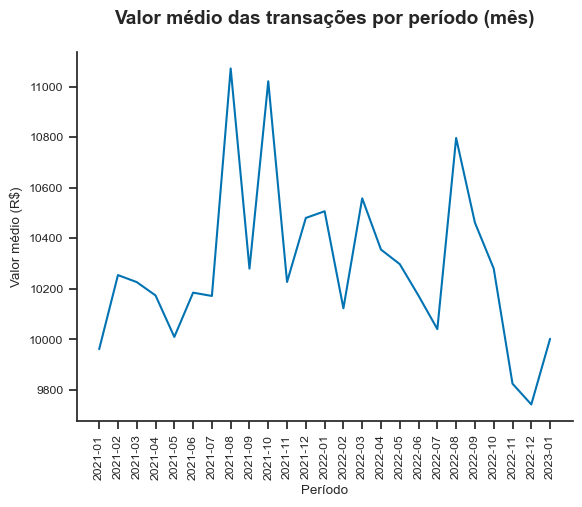

In [11]:
# Média de valor das transferências por período (mês)
data = spark.sql(
    '''
    SELECT
        DATE_FORMAT(transaction_date, 'yyyy-MM') AS periodo,
        AVG(valor) AS valor_medio
    FROM
        transacoes_pix
    GROUP BY
        periodo
    ORDER BY
        periodo ASC
    '''
).toPandas()

display(data.style.hide())
sns.lineplot(data=data, x='periodo', y='valor_medio')
plt.xticks(rotation=90);
sns.despine()
plt.title('Valor médio das transações por período (mês)')
plt.ylabel('Valor médio (R$)')
plt.xlabel('Período');

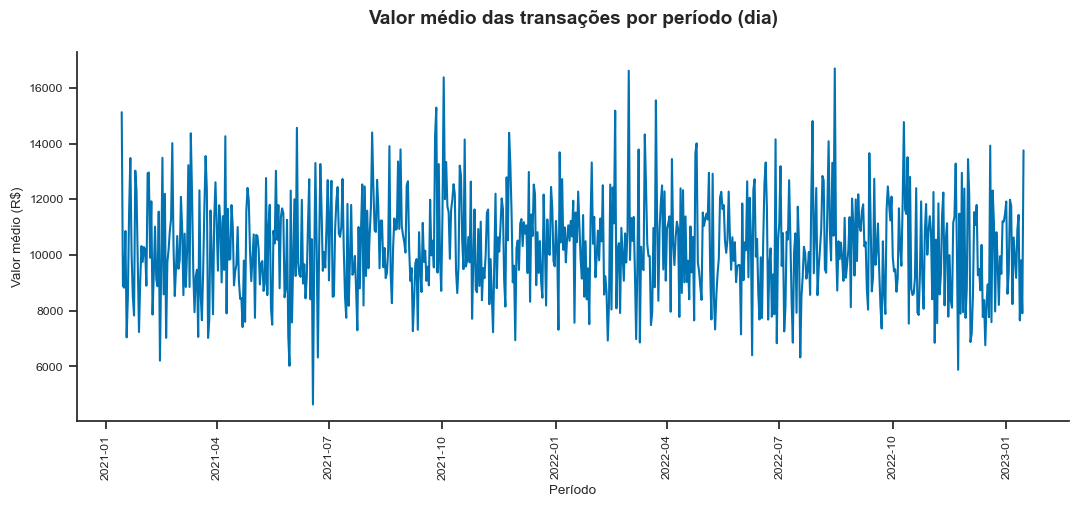

In [12]:
# Média de valor das transferências por período (dia)
data = spark.sql(
    '''
    SELECT
        DATE_FORMAT(transaction_date, 'yyyy-MM-dd') AS periodo,
        AVG(valor) AS valor_medio
    FROM
        transacoes_pix
    GROUP BY
        periodo
    ORDER BY
        periodo ASC
    '''
).toPandas()

data.loc[:, 'periodo'] = pd.to_datetime(data['periodo'], format='%Y-%m-%d')

plt.figure(figsize=(6.4*2, 4.8))
sns.lineplot(data=data, x='periodo', y='valor_medio')
plt.xticks(rotation=90);
sns.despine()
plt.title('Valor médio das transações por período (dia)')
plt.ylabel('Valor médio (R$)')
plt.xlabel('Período');

In [13]:
# Média de valor das transferências por período (dia da semana)
spark.sql(
    '''
    SELECT
        DATE_FORMAT(transaction_date, 'EEEE') AS dia_semana,
        AVG(valor) AS valor_medio
    FROM
        transacoes_pix
    GROUP BY dia_semana
    ORDER BY CASE WHEN dia_semana = 'Monday' THEN 1
                  WHEN dia_semana = 'Tuesday' THEN 2
                  WHEN dia_semana = 'Wednesday' THEN 3
                  WHEN dia_semana = 'Thursday' THEN 4
                  WHEN dia_semana = 'Friday' THEN 5
                  WHEN dia_semana = 'Saturday' THEN 6
                  ELSE 7 END
    '''
).show()

+----------+------------------+
|dia_semana|       valor_medio|
+----------+------------------+
|    Monday|10412.389798728838|
|   Tuesday| 10440.99404696807|
| Wednesday|10309.061532160407|
|  Thursday|10484.734799696053|
|    Friday|10069.232215940414|
|  Saturday|10281.954751861935|
|    Sunday|10126.436902093443|
+----------+------------------+



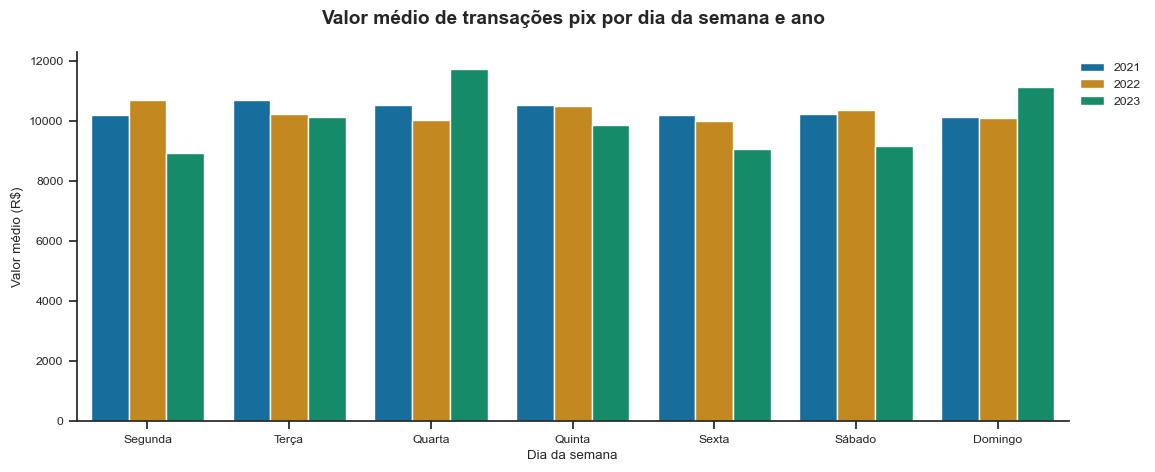

In [14]:
# Média de valor das transferências por período (dia da semana) por ano
data = spark.sql(
        '''
        SELECT
            CASE DATE_FORMAT(transaction_date, 'EEEE') 
                WHEN 'Monday' THEN 'Segunda'
                WHEN 'Tuesday' THEN 'Terça'
                WHEN 'Wednesday' Then 'Quarta'
                WHEN 'Thursday' THEN 'Quinta'
                WHEN 'Friday' THEN 'Sexta'
                WHEN 'Saturday' THEN 'Sábado'
                WHEN 'Sunday' THEN 'Domingo'          
            END AS dia_semana,
            YEAR(transaction_date) AS ano,
            AVG(valor) AS valor_medio
        FROM
            transacoes_pix
        GROUP BY ano, dia_semana
        ORDER BY 
            ano,
            CASE WHEN dia_semana = 'Segunda' THEN 1
                WHEN dia_semana = 'Terça' THEN 2
                WHEN dia_semana = 'Quarta' THEN 3
                WHEN dia_semana = 'Quinta' THEN 4
                WHEN dia_semana = 'Sexta' THEN 5
                WHEN dia_semana = 'Sábado' THEN 6
                ELSE 7 
            END;
        '''
).toPandas()

plt.figure(figsize=(6.4*2, 4.8))
sns.barplot(data=data, x='dia_semana', y='valor_medio', hue='ano', palette='colorblind')
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Valor médio de transações pix por dia da semana e ano')
plt.ylabel('Valor médio (R$)')
plt.xlabel('Dia da semana')
sns.despine();

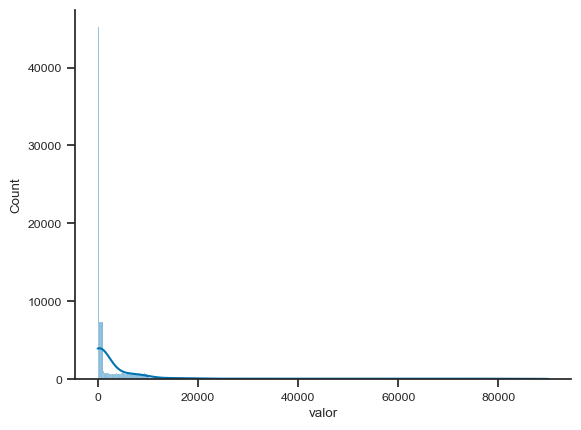

In [15]:
# Distribuição dos valores de transação
data = spark.sql(
    '''
    SELECT
        valor
    FROM
        transacoes_pix
    '''
).toPandas()

sns.histplot(data=data, x='valor', kde=True)
sns.despine()

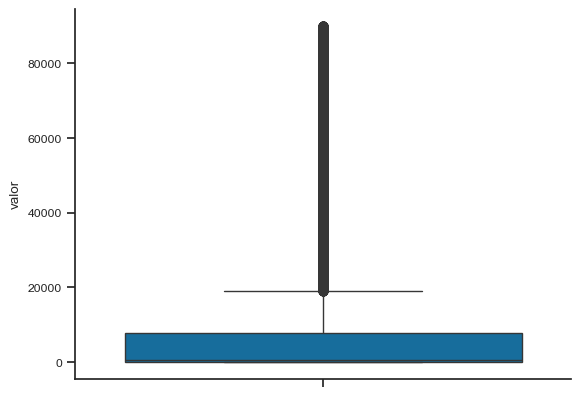

In [16]:
# Boxplot dos valores de transação
sns.boxplot(data=data, y='valor')
sns.despine()

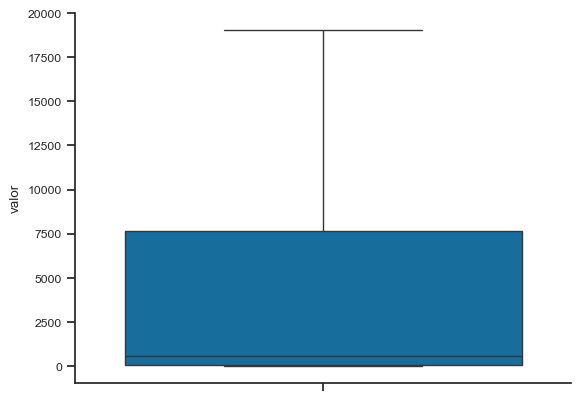

In [17]:
# Boxplot dos valores de transação s/ outliers (método iqr)
sns.boxplot(data=data, y='valor', showfliers=False)
sns.despine()

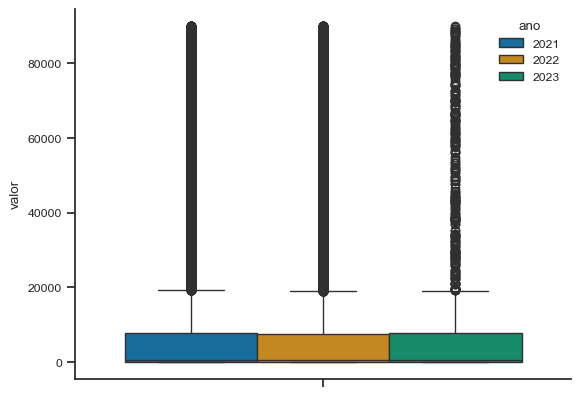

In [18]:
# Boxplot dos valores de transação por ano
data = spark.sql(
    '''
    SELECT
        valor, YEAR(transaction_date) AS ano
    FROM
        transacoes_pix
    '''
).toPandas()

sns.boxplot(data=data, y='valor', hue='ano', palette='colorblind')
sns.despine()

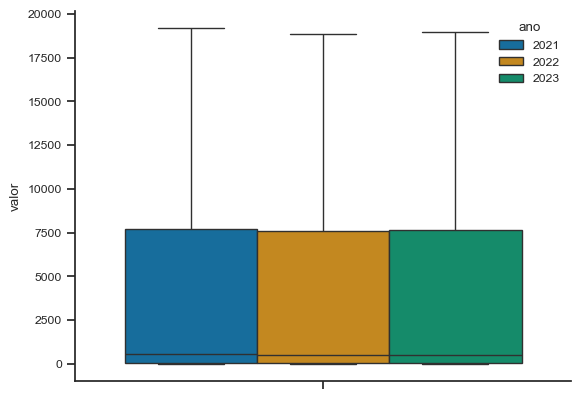

In [19]:
# Boxplot dos valores de transação por ano sem outliers (método iqr)
sns.boxplot(data=data, y='valor', hue='ano', palette='colorblind', showfliers=False)
sns.despine()